In [209]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from IPython.display import Markdown, display

In [2]:
def create_donut_charts(dataframes, column_names, titles=None):
    if titles is None:
        titles = column_names
        
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(7.5 * num_bar_charts, 6))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        print(values)
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            # colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(titles[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    # plt.show()
    return fig

In [270]:
outpath = Path('results/wallet_analysis')
outpath.mkdir(exist_ok=True)

wallet_df = pd.read_csv(Path('data/stETH_token_distribution.csv'))
wallet_df.loc[wallet_df.type.isna(), 'type'] = 'Other'
wallet_df['total_token_share'] = wallet_df['total'] / wallet_df['total'].sum() * 100

In [271]:
wallet_df.head()
print(len(wallet_df))

1208


In [272]:
threshold = 1.
wallet_types = {'Private'}

wallet_df.sort_values('total_token_share', ascending=False)
total_token_share_series = wallet_df[wallet_df.type.isin(wallet_types)].total_token_share
(total_token_share_series > threshold).sum()

5

In [273]:
def get_token_array(wallet_df, wallet_types):
    return np.array(
        wallet_df[wallet_df.type.isin(wallet_types)]['total_token_share'].sort_values(
            ascending=False))

def count_singles_threshold(wallet_df, wallet_types, threshold):
    token_array = get_token_array(wallet_df, wallet_types)
    count0 = np.sum(token_array > threshold)
    return count0, count0

def count_pairs_threshold(wallet_df, wallet_types, threshold):
    token_array = get_token_array(wallet_df, wallet_types)
    count0 = 0
    n = len(token_array)
    for pointer1 in range(n):
        count = np.sum((token_array[pointer1] + token_array[pointer1 + 1:]) > threshold)
        if count == 0:
            break
        count0 += count
    return count0, pointer1

def count_triplets_threshold(wallet_df, wallet_types, threshold):
    token_array = get_token_array(wallet_df, wallet_types)
    count0 = 0
    n = len(token_array)
    for pointer1 in range(n):
        count1 = 0
        for pointer2 in range(pointer1+1, n):
            count = np.sum(
                (token_array[pointer1] + token_array[pointer2] + 
                 token_array[pointer2 + 1:]
                ) > threshold 
            )
            if count == 0:
                break
            count1 += count
        if count1 == 0:
            break
        count0 += count1
    return count0, pointer1

def count_quadruplets_threshold(wallet_df, wallet_types, threshold):
    token_array = get_token_array(wallet_df, wallet_types)
    count0 = 0
    n = len(token_array)
    for pointer1 in range(n):
        count1 = 0
        for pointer2 in range(pointer1+1, n):
            count2 = 0
            for pointer3 in range(pointer2+1, n):
                count = np.sum(
                    (token_array[pointer1] + token_array[pointer2] + token_array[pointer3] +
                     token_array[pointer3 + 1:]
                    ) > threshold
                )
                if count == 0:
                    break
                count2 += count
            if count2 == 0:
                break
            count1 += count2
        if count1 == 0:
            break
        count0 += count1
    return count0, pointer1

threshold = 3.
wallet_types = ['Private']

print('thresh:', threshold)
print(count_singles_threshold(wallet_df, wallet_types, threshold))
print(count_pairs_threshold(wallet_df, wallet_types, threshold))
print(count_triplets_threshold(wallet_df, wallet_types, threshold))
# print(count_quadruplets_threshold(wallet_df, wallet_types, threshold))

thresh: 3.0
(1, 1)
(636, 2)
(207511, 4)


In [274]:
singles, pairs, triplets = [], [], []
thresholds = np.linspace(0.1, 5, 300)
for threshold in thresholds:
    singles.append(count_singles_threshold(wallet_df, wallet_types, threshold))
    pairs.append(count_pairs_threshold(wallet_df, wallet_types, threshold))
    triplets.append(count_triplets_threshold(wallet_df, wallet_types, threshold))
singles = np.array(singles)
pairs = np.array(pairs)
triplets = np.array(triplets)

In [275]:
df = pd.DataFrame(np.hstack([thresholds[:,np.newaxis], np.hstack([singles, pairs, triplets])]),
             columns=['threshold',
                      'single_wallets', 'single_wallets',
                      'pairs', 'pairs_distinct_first_wallets',
                      'triplets', 'triplets_distinct_first_wallets'
                     ])
df.head()

,threshold,single_wallets,single_wallets,pairs,pairs_distinct_first_wallets,triplets,triplets_distinct_first_wallets
0,0.100000,57.0,57.0,40217.0,129.0,14451629.0,193.0
1,0.116388,52.0,52.0,34456.0,108.0,11957697.0,170.0
2,0.132776,40.0,40.0,29522.0,87.0,10287554.0,152.0
3,0.149164,36.0,36.0,25196.0,74.0,8867512.0,130.0
4,0.165552,32.0,32.0,22213.0,64.0,7729753.0,115.0


In [276]:
sns.set_context('notebook')

Text(0.5, 1.0, 'Number of groups larger than threshold')

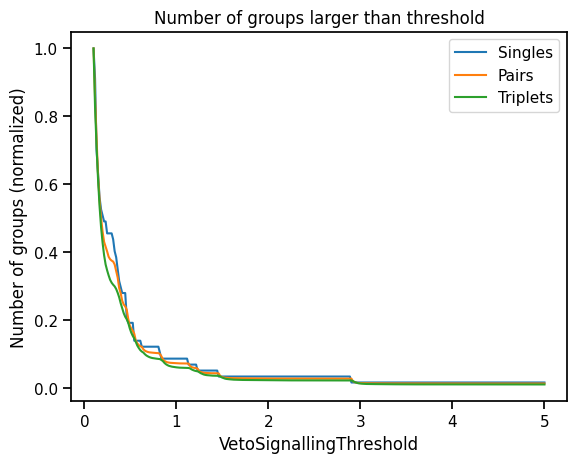

In [277]:
for arr, name in [(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets')]:
    plt.plot(thresholds, arr[:,0] / np.max(arr[:,0]), label=name.capitalize())
plt.legend()
plt.xlabel('VetoSignallingThreshold')
plt.ylabel('Number of groups (normalized)')
plt.title('Number of groups larger than threshold')

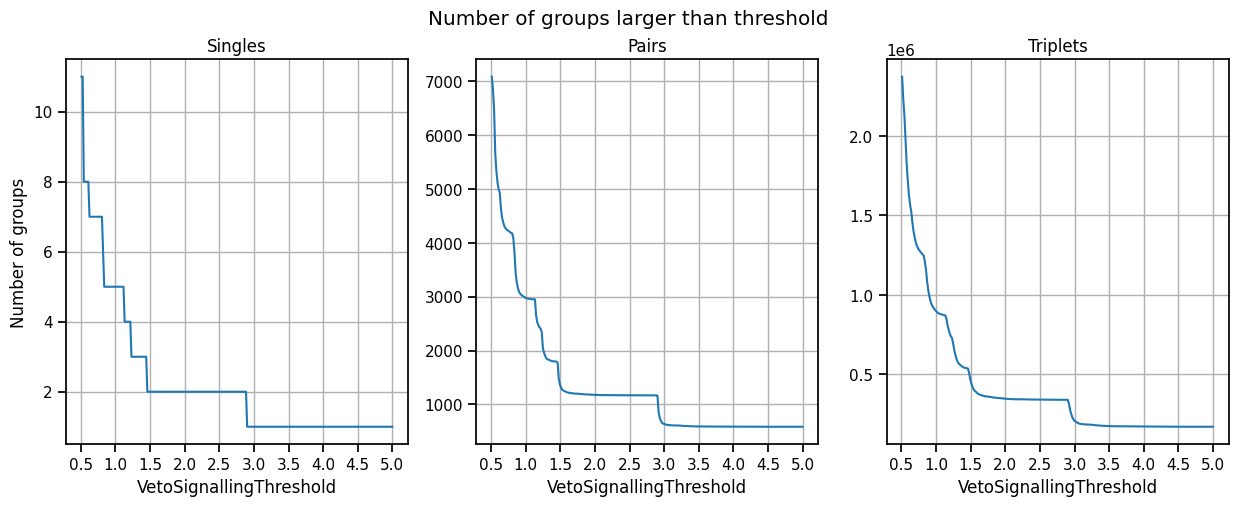

In [278]:
basesize = 5
ncols = 3
start = 0.5
step = 0.5
fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(basesize * ncols, basesize))
skip = np.sum(thresholds < start)
for i, (arr, name) in enumerate([(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets')]):
    axes[i].plot(thresholds[skip:], arr[skip:,0], label=name)
    axes[i].set_xlabel('VetoSignallingThreshold')
    axes[i].set_title(name.capitalize())
    axes[i].set_xticks(np.arange(start, 5+step, step))
    axes[i].grid()
axes[0].set_ylabel('Number of groups')
plt.suptitle('Number of groups larger than threshold');

In [279]:
len(token_array)

1037

##### This means that to form a group of k wallets that collectively holds more tokens than a threshold one of these wallets has to participate.

##### For example there are 360206 triplets at threshold=1.74, but each of these triplets contains one of the 7 first largest wallets. Without these first 7 wallets, large enough triplet cannot be formed.

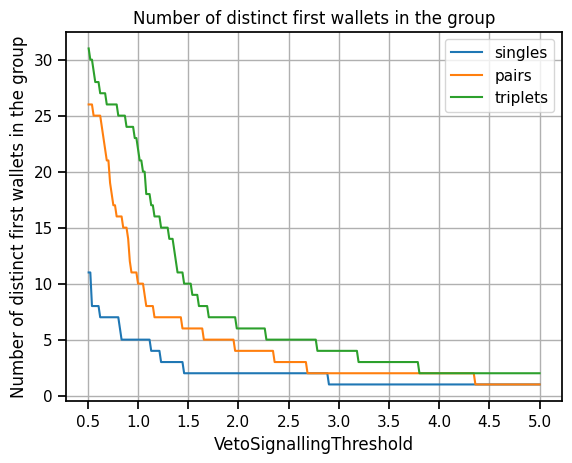

In [280]:
skip = np.sum(thresholds < start)
for arr, name in [(singles, 'singles'), (pairs, 'pairs'), (triplets, 'triplets')]:
    plt.plot(thresholds[skip:], arr[skip:,1], label=name)
plt.legend()
plt.xlabel('VetoSignallingThreshold')
plt.ylabel('Number of distinct first wallets in the group')
plt.title('Number of distinct first wallets in the group')
plt.xticks(np.arange(start, 5+step, step))
plt.grid()

display(Markdown(f"##### This means that to form a group of k wallets that collectively holds more tokens than a threshold one of these wallets has to participate."))
i = 100
display(Markdown(f"##### For example there are {triplets[i,0]} triplets at threshold={thresholds[i]:.2f}, but each of these triplets contains one of the {triplets[i,1]} first largest wallets. Without these first {triplets[i,1]} wallets, large enough triplet cannot be formed."))

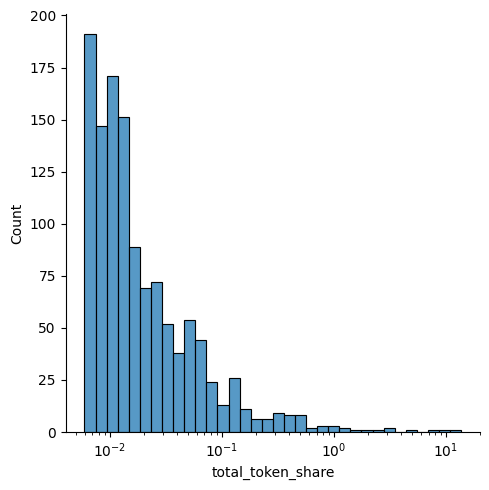

In [4]:
sns.displot(wallet_df['total_token_share'], log_scale=True)

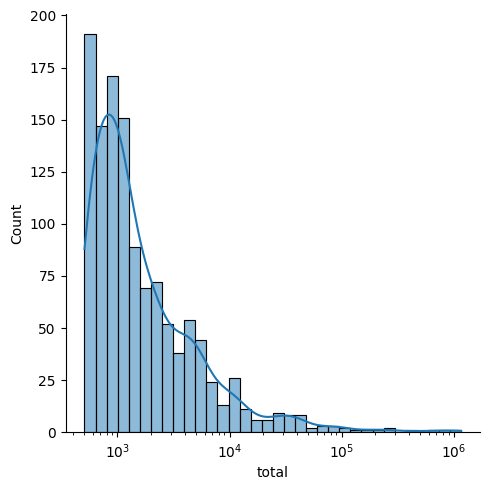

In [5]:
sns.displot(wallet_df.total, log_scale=True, kde=True)

0.8464131219739289
4278.871026
4278871025999999926272


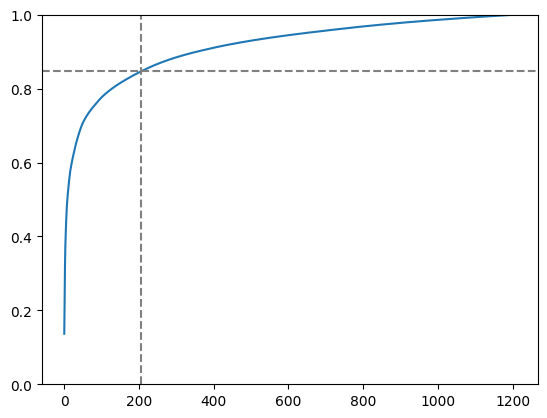

In [26]:
threshold = 0.05
balance = sorted(wallet_df.total)[::-1]
points = np.cumsum(balance) / wallet_df.total.sum()
plt.plot(points)
mask = wallet_df.total_token_share > threshold
x = np.sum(mask)
y = wallet_df[mask].total_token_share.sum() / 100
plt.plot([x, x], [0, 1], color='grey', linestyle='--')
xlim = plt.xlim()
plt.plot(xlim, [y, y], color='grey', linestyle='--')
plt.xlim(xlim)
plt.ylim(0,1)
print(y)
print(wallet_df[mask].total.min())
print(int(wallet_df[mask].total.min() * 10 **18))
# sns.displot(np.cumsum(balance), log_scale=True, kind='ecdf')

In [30]:
int(wallet_df.total.sum() * 10 ** 18)

8536242865911699582484480

In [16]:
wallet_df[mask & (wallet_df.type == 'Private')].total_token_share.sum()

26.081351101802518

In [17]:
wallet_df[mask & (wallet_df.type != 'Private')].total_token_share.sum()

51.65981109787717

In [7]:
print('mean token share:', f'{wallet_df.total_token_share.mean():.3f}%')
print('median token share:', f'{wallet_df.total_token_share.median():.3f}%')
print('mode token share:', f'{wallet_df.total_token_share.mode().iloc[0]:.3f}%')

mean token share: 0.083%
median token share: 0.013%
mode token share: 0.012%


In [73]:
threshold = 1
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 1.000% of all tokens: 13
These wallets collectively hold 54.268% of all tokens


In [71]:
threshold = 0.5
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 0.500% of all tokens: 22
These wallets collectively hold 60.499% of all tokens


In [72]:
threshold = 0.1
mask = wallet_df.total_token_share >= threshold
wallet_count = np.sum(mask)
print(f'Number of wallets holding more than {threshold:.3f}% of all tokens: {wallet_count}')
total_share = np.sum(wallet_df[mask]['total_token_share'].sum())
print(f'These wallets collectively hold {total_share:.3f}% of all tokens')

Number of wallets holding more than 0.100% of all tokens: 102
These wallets collectively hold 77.741% of all tokens


In [39]:
wallet_type_summary = wallet_df.groupby('type').sum(numeric_only=True)
wallet_type_summary['wallet_count'] = wallet_df.groupby('type').count()['address']
wallet_type_summary

,stETH,wstETH,total,wallet_count
type,,,,
CEX,1.091492e+05,3.834860e+03,1.136502e+05,8
Contract,2.023537e+06,2.175870e+06,4.577356e+06,152
Custody,2.853018e+04,4.238680e+04,7.827957e+04,11
Private,2.526655e+06,1.056745e+06,3.766957e+06,1037


type
CEX            8
Contract     152
Custody       11
Private     1037
Name: wallet_count, dtype: int64
type
CEX         1.136502e+05
Contract    4.577356e+06
Custody     7.827957e+04
Private     3.766957e+06
Name: total, dtype: float64


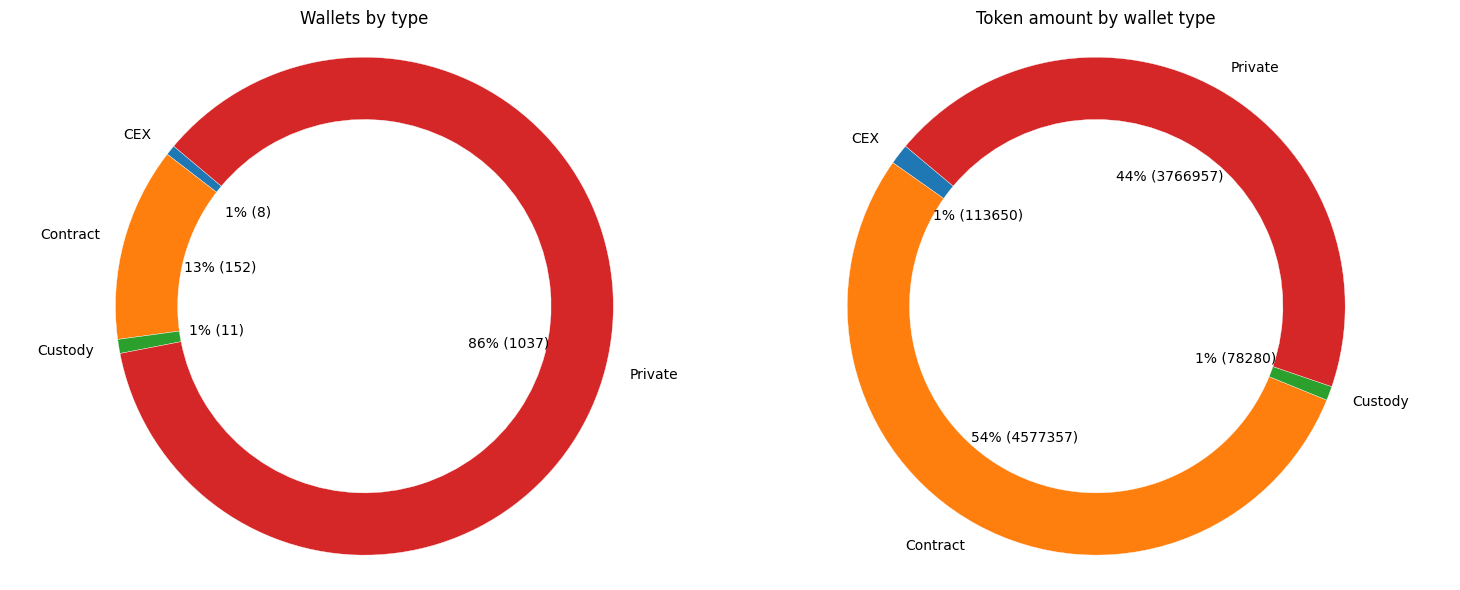

In [54]:
fig = create_donut_charts([wallet_type_summary, wallet_type_summary], ['wallet_count', 'total'], ['Wallets by type', 'Token amount by wallet type']);
fig.savefig(outpath.joinpath('wallet_type_piechart.png'))

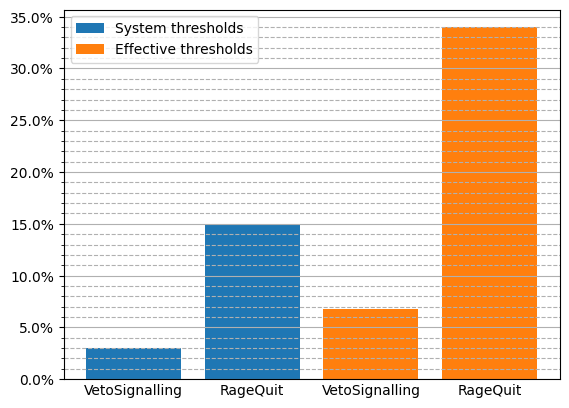

In [81]:
active_percent = wallet_type_summary['total']['Private'] / wallet_type_summary['total'].sum()

default_percents = np.array([3, 15])
plt.bar([0,1], default_percents, label='System thresholds')
plt.bar([2,3], default_percents / active_percent, label='Effective thresholds')
plt.xticks([0,1,2,3], labels=['VetoSignalling', 'RageQuit', 'VetoSignalling', 'RageQuit'])
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))
plt.gca().tick_params(axis=u'x', which=u'both',length=0)
plt.grid(True, axis='y')
plt.gca().grid(True, axis='y', which='minor', linestyle='--')
plt.legend()
plt.savefig(outpath.joinpath('effective_threshold_barchart.png'))

In [112]:
wallet_df['share'] = wallet_df.total / wallet_df.total.sum()
share_df = wallet_df[wallet_df.type == 'Private'].sort_values(by='total', ascending=False).copy()
share_df

,address,stETH,wstETH,total,label,type,protocol_type,share
3,0x98078db053902644191f93988341e31289e1c8fe,453283.812900,0.00000,453283.812900,Private Transactions Miner [0x6b764a],Private,NaN,0.053101
5,0xc329400492c6ff2438472d4651ad17389fcb843a,0.000000,210603.20510,247184.981800,clonmel.eth [0x9d91ae],Private,NaN,0.028957
8,0x48d62ed012e327faacb9c8d2a56330e215da0575,0.000000,105695.13730,124054.382600,EIP 1559 User [0x5a1f9d],Private,NaN,0.014533
9,0x3c22ec75ea5d745c78fc84762f7f1e6d82a2c5bf,9543.968864,80790.22584,104367.456900,pewpews.eth [0xa626bd],Private,NaN,0.012226
10,0x43594da5d6a03b2137a04df5685805c676def7cb,96252.516950,0.00000,96252.516950,High Balance [0x8d249e],Private,NaN,0.011276
...,...,...,...,...,...,...,...,...
1203,0x3fa930a14c9a35b6d4b3babaae395384eadd0d1f,510.591493,0.00000,510.591493,NaN,Private,NaN,0.000060
1204,0xc4652535aad91abbb4cc90f3f474e9f765003e05,509.909753,0.00000,509.909753,NaN,Private,NaN,0.000060
1205,0xa2694887f13a7bfee00824ba02b38ae848779136,509.548730,0.00000,509.548730,NaN,Private,NaN,0.000060
1206,0x3f1131d2107c6fd8d1f7f3808dfccefe5afcf6fe,509.286951,0.00000,509.286951,NaN,Private,NaN,0.000060


In [130]:
print('Only the largest wallet can overcome the VS threshold')
count0 = len(share_df) - 1
print(f'{count0} other wallets can join the largest wallet')
count1 = np.sum((share_df.drop([3,5]).share + share_df.loc[5].share) >= 0.03)
print(f'{count1} smaller wallets can overcome the VS threshold with the second largest wallet')
count2 = np.sum((share_df.drop([3,5,8]).share + share_df.loc[8].share) >= 0.03)
print(f'{count2} smaller wallets can overcome the VS threshold with the third largest wallet')
print(f'So {count0 + count1 + count2} total pairs, but they contain either the first or the second largest wallets')

Only the largest wallet can overcome the VS threshold
1036 other wallets can join the largest wallet
52 smaller wallets can overcome the VS threshold with the second largest wallet
0 smaller wallets can overcome the VS threshold with the third largest wallet
So 1088 total pairs, but they contain either the first or the second largest wallets


### Todo count triplets in the same manner. Meaning count triplets with the second largest wallet and wallets not in the count1, the third largest wallet

In [156]:
share_df_d = share_df.drop([3,5])
mask = (share_df_d.share + share_df.loc[5].share) < 0.03

count3 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[99].share + share_df_d[mask].drop([99]).share) >= 0.03)
count4 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[100].share + share_df_d[mask].drop([99,100]).share) >= 0.03)
count5 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[101].share + share_df_d[mask].drop([99,100, 101]).share) >= 0.03)
count6 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[105].share + share_df_d[mask].drop([99,100, 101,105]).share) >= 0.03)
count7 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[106].share + share_df_d[mask].drop([99,100, 101,105,106]).share) >= 0.03)
count8 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[107].share + share_df_d[mask].drop([99,100, 101,105,106,107]).share) >= 0.03)
count9 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[109].share + share_df_d[mask].drop([99,100, 101,105,106,107,109]).share) >= 0.03)
count10 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[111].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111]).share) >= 0.03)
count11 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[113].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111,113]).share) >= 0.03)
count12 = np.sum((share_df.loc[5].share + share_df_d[mask].loc[115].share + share_df_d[mask].drop([99,100, 101,105,106,107,109,111,113,115]).share) >= 0.03)
print(count3, count4, count5, count6, count7, count8, count9, count10, count11, count12)

982 981 980 634 361 350 321 290 245 232


In [149]:
share_df_d[mask].head(10)

,address,stETH,wstETH,total,label,type,protocol_type,share
99,0x1a5213554ac2f7056c554fb19416ff9738e165ba,8846.902577,0.000000,8846.902577,haos.eth [0x1a5213],Private,NaN,0.001036
100,0x98ec0508e134dfee2992e42577696625768be437,8757.369407,0.000000,8757.369407,Token Millionaire [0x98ec05],Private,NaN,0.001026
101,0xa5d223c176daab154a3134369d1c0478c5e6fecf,0.000000,7305.219814,8574.136496,10248.eth* [0xa5d223],Private,NaN,0.001004
105,0xb3668730e4a8abe282a6d471c75baf75557ffff3,0.000000,6885.493147,8081.503306,Token Millionaire [0x4992c5],Private,NaN,0.000947
106,0x46cd2870894a9a7d5eedbb40997d994fa8a058df,7658.563187,0.000000,7658.563187,Token Millionaire [0x46cd28],Private,NaN,0.000897
107,0xfc09d8c9a63670702c2de876ff95608ab971dcd6,7621.633895,0.000000,7621.633895,Token Millionaire [0xfc09d8],Private,NaN,0.000893
109,0x4a240f0ee138697726c8a3e43efe6ac3593432cb,0.000000,6412.794919,7526.697396,Gnosis Safe MultiSig,Private,NaN,0.000882
111,0x0685c5aed38f038d984e8dc7dc8ad8783f166f35,0.000000,6300.000000,7394.310000,Token Millionaire,Private,NaN,0.000866
113,0xa3726bedfd1a8aa696b9b4581277240028c4314b,0.000000,6121.661852,7184.994516,Token Millionaire,Private,NaN,0.000842
115,0x720d8790666bd40b9ca289cbe73cb1334f0ae7e3,7101.672500,0.000000,7101.672500,Gnosis Safe MultiSig,Private,NaN,0.000832


So there are much more triplets that can put the system into VetoSignalling. TODO exaustive counting

In [40]:
data = np.random.normal(size=(1000, 10000))


In [41]:
print(np.std(np.mean(data > 0, axis=1)))
print(np.std(data > 0, axis=(0,1)))

0.0049855416395814
0.4999999552254378
